<a href="https://colab.research.google.com/github/seanshlee/DL-proj/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #구글 드라이브에 연결하는 코드

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np 
import pickle

device = 'cuda' if torch.cuda.is_available() else 'cpu' #GPU 사용 설정

train_dataset_path = '/content/drive/MyDrive/emotion_proj/data/emo_train_dataset_0508.pkl' 
test_dataset_path = '/content/drive/MyDrive/emotion_proj/data/emo_test_dataset_0508.pkl'

In [ ]:
#train_dataset, test_dataset pkl 파일 불러오기 
with open(train_dataset_path, 'rb') as f:
  train_dataset = pickle.load(f)

with open(test_dataset_path, 'rb') as f:
  test_dataset = pickle.load(f)

In [ ]:
#라벨값에 해당하는 숫자를 label_set에 저장.
label_set = {'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6,
}

In [ ]:
#라벨값 숫자로 변환해서 train_data에 저장
#img 차원값이 맨 앞으로 오도록 reshape (torch 포맷에 맞게)

train_data = []
for img, label in train_dataset:
  train_data.append((img.reshape(1,48,48), label_set[label]))

In [ ]:
#라벨값 숫자로 변환해서 test_data에 저장
#img 차원값이 맨 앞으로 오도록 reshape (torch 포맷에 맞게)

test_data = []
for img, label in test_dataset:
  test_data.append((img.reshape(1,48,48), label_set[label]))

In [ ]:
#자료형을 텐서로 변경해서 train, test에 저장. -> Data load 할 준비 완료
train = [(torch.tensor(im, dtype=torch.float32),torch.tensor(label, dtype=torch.long)) for im,label in train_data]
test = [(torch.tensor(im,dtype=torch.float32),torch.tensor(label, dtype=torch.long)) for im,label in test_data]

In [ ]:
#Hyper parameter 설정 
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-3

In [ ]:
# DataLoader 
train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle=True) #drop_last = True
test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle=True) #drop_last = True

# 전이학습



In [ ]:
from torchvision import models

# pre trained model
model = models.resnet18()

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=7)

In [ ]:
model.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
# model.relu = nn.ReLU(inplace=True)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

49번째 train_loss : 0.04 test_loss : 3.39 Accuracy : 70.0%
Best accuracy 70.55% achieved at epoch 26


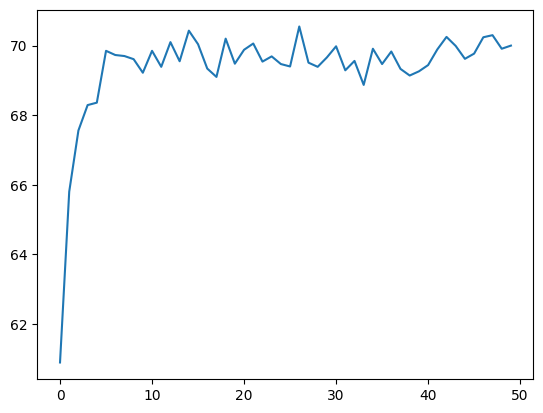

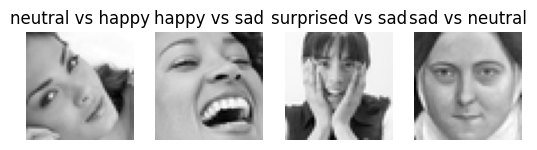

In [ ]:
import numpy as np
from tqdm.auto import tqdm
from IPython.display import clear_output
total = 0
correct = 0
##############
total_acc = []
best_acc = 0
best_epoch = 0
patience = 25
counter = 0
#학습진행
losses = []
for epoch in range(EPOCHS):
  train_loss=[]
  for img, label in train_loader:
    optimizer.zero_grad()
    pred = model(img.to(device))
    loss = criterion(pred, label.to(device))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  losses.append(np.array(train_loss).mean())
#평가
  test_loss= []
  test_sources = []
  with torch.no_grad():
    for img, label in test_loader:
      pred = model(img.to(device))
      ###
      # _, predicted = torch.max(pred.data, 1) #가장 높은 확률값으로 예측된 클래스
      # total += label.size(0) #전체 데이터 개수 증가
      # correct += (predicted == label.to(device)).sum().item() #예측값과 실제값이 일치하는 경우 개수 증가
      ###
      loss = criterion(pred, label.to(device))
      test_loss.append(loss.item())
      test_sources.append((img[pred.cpu().argmax(axis=1)!=label.cpu()],
      label[pred.cpu().argmax(axis=1)!=label.cpu()],pred.cpu().argmax(axis=1)[pred.cpu().argmax(axis=1)!=label.cpu()]))
  clear_output()
  # 인식 잘 안된 부분의 시각화를 위해서 img, label, pred를 모아서 정리
  imgs = [x[0] for x in test_sources]
  imgs = torch.cat(imgs, axis=0)
  labels = [x[1] for x in test_sources]
  labels = torch.cat(labels, axis=0)
  preds = [x[2] for x in test_sources]
  preds = torch.cat(preds, axis=0)

  # 정확도 계산을 위한 코드. 다양하게 다른 방법도 가능함
  wrongs = [len(x[0]) for x in test_sources]
  acc = round(100-(sum(wrongs)/100),2)

  # 정확도 추이를 보기 위하여 각 에폭에서의 정확도 정보 수집
  total_acc.append(acc)
  
  # 학습 진행 상황 출력
  print("{}번째 train_loss : {} test_loss : {} Accuracy : {}%".format(epoch, round(np.array(train_loss).mean(),2),round(np.array(test_loss).mean(),2),
                                                                   acc))
  if img.shape[0]<1:continue # 혹시 더이상 오분류 내용이 없으면 지나가도록 세팅
  
  #가장 높은 정확도를 달성한 epoch 정보 저장
  if acc > best_acc:
    best_acc = acc
    best_epoch = epoch
    counter = 0
    torch.save(model.state_dict(), 'best_model.pt')
  else :
    counter += 1
    if counter >= patience:
      print("Early stopping...")
      break
  print("Best accuracy {}% achieved at epoch {}".format(best_acc, best_epoch))
  
  # 정확도 그래프 그리기
  plt.plot(total_acc)
  plt.show()
  plt.title("label vs pred")
  label_list = ['angry','disgusted','fearful','happy','neutral','sad','surprised']
  
  # 오분류 내용이 어떤건지 알기 위해 오분류 내용 4개 뽑아서 label과 pred 글자 넣어서 표시
  for i in range(4):
    plt.subplot(1,4,i+1)
    label = label_list[labels[i].item()]
    pred = label_list[preds[i].item()]    
    plt.imshow(imgs[i][0], cmap='gray')    
    plt.title("{} vs {}".format(label,pred))
    plt.axis('off')
  plt.show()